<a href="https://colab.research.google.com/github/drshahizan/Python_EDA/blob/main/assignment/ass3/hpdp/PERgolakan/ass3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assingment 3: eCommerce behavior data from multi category store <a href="https://www.utm.my" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group Members

|    Name           |           Matric Number       |                      
|-------------------|-------------------------------|
|Muhammad Fikri Bin Sharunazim    | A21EC0075       |
|Muhammad Farhan Bin Ibrahim|        A21EC0072      |
|Muhammad Adam Fahmi Bin Mohd Taufiq |A21EC0061|
|Mikhail Bin Yassin |A21EC0053                      |

---




##1. Dataset Selection
**eCommerce behavior data from multi category store**

This file contain behavior data for 7 months (from October 2019 to April 2020) from a large multi-category online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.

Data collected by Open CDP project. Feel free to use open source customer data platform.

How to read it
There are different types of events. See below.

[ Semantics (or how to read it): User user_id during session user_session added to shopping cart (property event_type is equal cart) product product_id of brand brand of category category_code (category_code) with price price at event_time ]

-------------------------------------------------------------------------

**File structure:**

'event_time' = Time when event happened at (in UTC).

'event_type' = Only one kind of event: purchase.

'product_id' = ID of a product.

'category_id' = Product's category ID.

'category_code' = Product's category taxonomy (code name) if possible. Usually present for meaningful categories, skipped for accessories.

'brand' = Downcased string of brand name. Can be missed.

'price' = Float price of a product. Present.

'user_id' = Permanent user ID.

'user_session' = Temporary user's session ID. Same for each user's session. Changes when the user returns from a long pause.

--------------------------------------------------------------------------

**Event types**
Events can be:

- view - a user viewed a product
- cart - a user added a product to shopping cart
- remove_from_cart - a user removed a product from shopping cart
- purchase - a user purchased a product

-------------------------------------------------------------------------

**Note that**:
Multiple purchases per session

A session can have multiple purchase events. It's ok, because it's a single order.

## 2. Data Acquisition

Install kaggle data in Google Colab by download and unzip the folder in order to obtain dataset '2019-Oct.csv'

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store
! unzip ecommerce-behavior-data-from-multi-category-store.zip

 99% 4.27G/4.29G [00:45<00:00, 136MB/s]
100% 4.29G/4.29G [00:45<00:00, 100MB/s]
Archive:  ecommerce-behavior-data-from-multi-category-store.zip
  inflating: 2019-Nov.csv            
  inflating: 2019-Oct.csv            


## 3. Setting Up the Environment

Import necessaries tools & libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Remove unused datasets and folder to minimize disk storage

In [ ]:
os.remove('2019-Nov.csv')
os.remove('ecommerce-behavior-data-from-multi-category-store.zip')

Read '2019-Oct.csv' dataset and in this assignment we exclude 'user_session' column because we don't use it.

In [ ]:
# Reading the data in chunks
data = pd.read_csv('2019-Oct.csv', chunksize=300000)

# Concatenating the chunks together
df = pd.concat(data)

Overview of the dataset

In [ ]:
df.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8


Display number of rows & columns

In [ ]:
# number of rows & columns
df.shape

(42448764, 9)

## 4. Data Preprocessing

### 4.1 Handling Missing Values

Check for missing values in each columns

In [ ]:
# check for missing values
df.isna().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

We can see that there are missing values in columns 'category_code' and 'brand', Hence we will drop the missing values in next step.

In [ ]:
# drop rows where 'user_session', 'category_code' and 'brand' is NaN
df.dropna(subset=['category_code'], inplace=True)
df.dropna(subset=['brand'], inplace=True)
df.dropna(subset=['user_session'], inplace=True)

### 4.2 Change DataType

In this section, we observe the data type of each columns. Our focus is to minimize as we can the memory usage in this dataset. Therefore, we will change data type of each columns into efficient data type.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26560620 entries, 1 to 42448762
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.0+ GB


In [ ]:
df['user_session'] = df['user_session'].astype('string')

#### 4.2.1 Date

First, we change 'event_time' column data type from objects into datetime. Due to high number of rows we use chunking method in order to minimize the RAM usage

In [ ]:
cols = ["event_time"]
date_format = "%Y-%m-%d"  # Define the desired date format

chunk_size = 300000
df_len = len(df)

for i in range(0, df_len, chunk_size):
    chunk = df.iloc[i:i + chunk_size].copy()  # Extract a chunk of data

    # Parse 'event_time' column to datetime format
    chunk['event_time'] = pd.to_datetime(chunk['event_time'])

    # Format 'event_time' column as "yyyy-mm-dd"
    chunk['event_time'] = chunk['event_time'].dt.strftime(date_format)

    # Update the original 'df' with the modified 'event_time' column
    df.iloc[i:i + chunk_size, df.columns.get_loc('event_time')] = chunk['event_time']

Change 'event_time' column data type from objects into datetime

In [ ]:
df['event_time']=pd.to_datetime(df['event_time'], errors="coerce")

#### 4.2.2 Numerical

Next, we find the max and min value in 'product_id' column to ensure if we can reduce the size of the data type.

In [ ]:
# check 'product_id' column highest value
max_value = df['product_id'].max()
# check 'product_id' column lowest value
min_value = df['product_id'].min()

print(f"The highest value in 'product_id': {max_value}")
print(f"The lowest value in 'product_id': {min_value}")

The highest value in 'product_id': 60500010
The lowest value in 'product_id': 1000978


We change 'product_id' column data type from int64 into int32

In [ ]:
# change the datatype 'product_id' from int64 to int32
df['product_id'] = df['product_id'].astype('int32')

Then, we find the max and min value in 'category_id' column to ensure if we can reduce the size of the data type.

In [ ]:
# check 'category_id' column highest value
max_value = df['category_id'].max()
# check 'product_id' column lowest value
min_value = df['category_id'].min()

print(f"The highest value in 'category_id': {max_value}")
print(f"The lowest value in 'category_id': {min_value}")

The highest value in 'category_id': 2173216765583032544
The lowest value in 'category_id': 2053013552226107603


Due to the max and min value of 'category_id' is to high, we maintain the data type

Then, we find the max and min value in 'user_id' column to ensure if we can reduce the size of the data type.

In [ ]:
# check 'user_id' column highest value
max_value = df['user_id'].max()
# check 'user_id' column lowest value
min_value = df['user_id'].min()

print(f"The highest value in 'user_id': {max_value}")
print(f"The lowest value in 'user_id': {min_value}")

The highest value in 'user_id': 566280697
The lowest value in 'user_id': 33869381


We change 'user_id' column data type from int64 into int32

In [ ]:
# change the datatype 'user_id' from int64 to int32
df['user_id'] = df['user_id'].astype('int32')

We find the max and min value in 'price' column to ensure if we can reduce the size of the data type.

In [ ]:
# check 'price' highest value
highest_value = df['price'].max()

# check 'price' lowest value
lowest_value = df['price'].min()

print(f"The highest value in the price is: {highest_value}")
print(f"The lowest value in the price is: {lowest_value}")

The highest value in the price is: 2574.07
The lowest value in the price is: 0.88


We noticed that, we can reduce it by convert float64 into float32

In [ ]:
#change 'price' from float64 to float32
df['price'] = df['price'].astype('float32')

#### 4.2.3 Categorical

Then, for categorical we observe the columns and decide whether we set them as category or strings or let it maintain as objects

In [ ]:
# check the unique value in dataset
value_counts = df['event_type'].value_counts()
print(value_counts)

unique_values = df['event_type'].unique()
print(unique_values)

view        25201706
cart          809407
purchase      549507
Name: event_type, dtype: int64
['view' 'purchase' 'cart']


Change 'event_type' from objects to category

In [ ]:
# change 'event_type' from object to categorical
df['event_type'] = df['event_type'].astype('category')

Change 'category_code' from objects to category

In [ ]:
# change 'category_code' from object to string
df['category_code'] = df['category_code'].astype('category')

In [ ]:
# check the unique value in brand
value_counts = df['brand'].value_counts()
print(value_counts)

unique_brand_count = df['brand'].nunique()
print("Number of unique brands:", unique_brand_count)

samsung      5158902
apple        4092652
xiaomi       2697644
huawei       1092346
lg            508999
              ...   
zazu               1
yison              1
tigres             1
bodykraft          1
ismart             1
Name: brand, Length: 1731, dtype: int64
Number of unique brands: 1731


Change 'brand' from objects to category

In [ ]:
# change 'brand' from object to string
df['brand'] = df['brand'].astype('category')

### 4.3 Handling duplicates

Find the total num of rows that are duplicates

In [ ]:
df.duplicated().sum()

8769117

Drop the duplicated rows from the dataset

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17791503 entries, 1 to 42448759
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   event_type     category      
 2   product_id     int32         
 3   category_id    int64         
 4   category_code  category      
 5   brand          category      
 6   price          float32       
 7   user_id        int32         
 8   user_session   string        
dtypes: category(3), datetime64[ns](1), float32(1), int32(2), int64(1), string(1)
memory usage: 814.5 MB


As we can see, we successfully to reduce the memory usage from 2.8+GB into 814.5 MB by:

- Handle the missing values
- Change the data type of each columns
- Handle duplicates in dataset

Therefore, the memory usage has been reduced by approximately 70.89%.

## 5. Exploratary Data Analysis

### 5.1 Summary Statistics

This will show:

- the count of that variable
- the mean
- the standard deviation (std)
- the minimum value
- the IQR (Interquartile Range: 25%, 50% and 75%)
- the maximum value

In [ ]:
summary_stats = df['price'].describe()

summary_stats

count    1.779150e+07
mean     3.652847e+02
std      3.958857e+02
min      8.800000e-01
25%      1.075000e+02
50%      2.213400e+02
75%      4.633300e+02
max      2.574070e+03
Name: price, dtype: float64

In [ ]:
category_columns = df.select_dtypes(include='category')
category_description = df[category_columns.columns].describe()
print(category_description)

       event_type           category_code     brand
count    17791503                17791503  17791503
unique          3                     126      1731
top          view  electronics.smartphone   samsung
freq     16736551                 7752069   3419946


### 5.2 Data Visualization

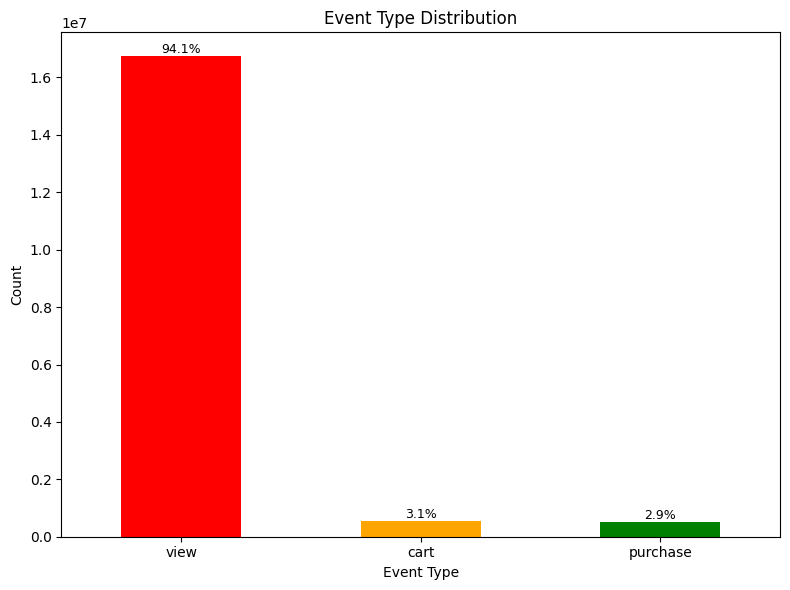

In [ ]:
event_type_counts = df['event_type'].value_counts()

# Define colors for each bar
colors = ['red', 'orange', 'green', 'skyblue']  # Add more colors as needed for additional event types

plt.figure(figsize=(8, 6))
ax = event_type_counts.plot(kind='bar', color=colors)
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Adding text labels above each bar
total_count = event_type_counts.sum()
for i, count in enumerate(event_type_counts):
    percentage = (count / total_count) * 100
    plt.text(i, count + 5, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


The event type "view" holds the highest value among other event type which is "cart" and "purchase".

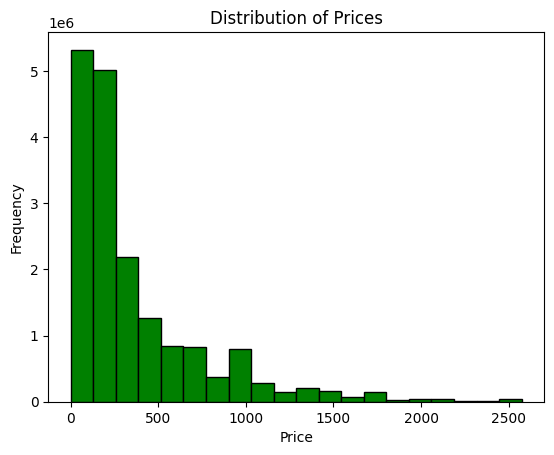

In [ ]:
# 'price' distribution
plt.hist(df['price'], bins=20, color='green', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Prices')
plt.show()


The graph shows that the majority of prices fall between 0 and 500, with a sharp decrease in frequency as the price increases.

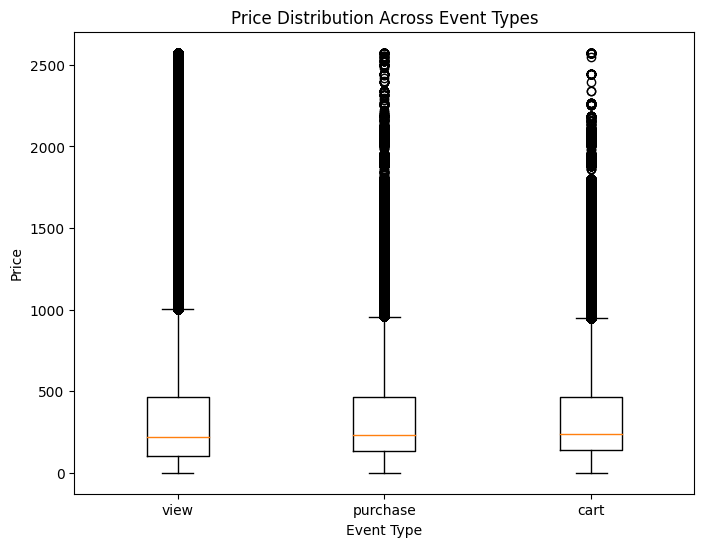

In [ ]:
# Box Plot for Prices Across Event Types
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['event_type'] == et]['price'] for et in df['event_type'].unique()], labels=df['event_type'].unique())
plt.title('Price Distribution Across Event Types')
plt.xlabel('Event Type')
plt.ylabel('Price')
plt.show()


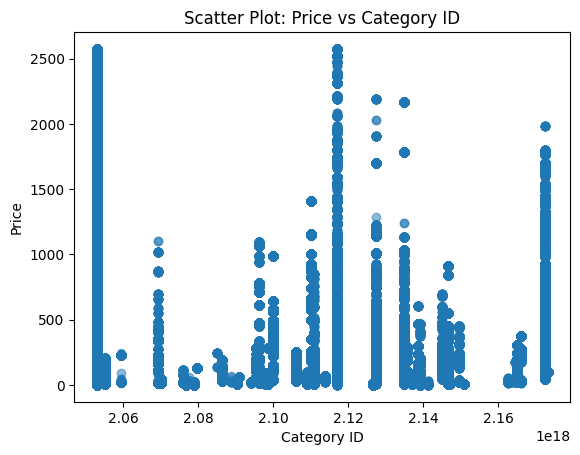

In [ ]:
# Scatter plot for 'price' vs 'category_id'
plt.scatter(df['category_id'], df['price'], alpha=0.5)
plt.xlabel('Category ID')
plt.ylabel('Price')
plt.title('Scatter Plot: Price vs Category ID')
plt.show()

The scatter plot illustrates the distribution of prices across different category IDs. Each point represents a data point where the x-coordinate corresponds to the 'Category ID' and the y-coordinate corresponds to the 'Price'.

<ipython-input-38-6259d1c52006>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


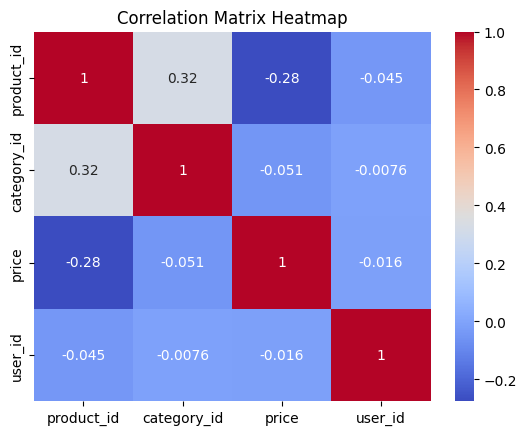

In [ ]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Based on the heatmap illustrates above, we can conclude that there is positive correlation coefficient between 'category_id' and 'product_id'. But the correlation is not extremely strong.

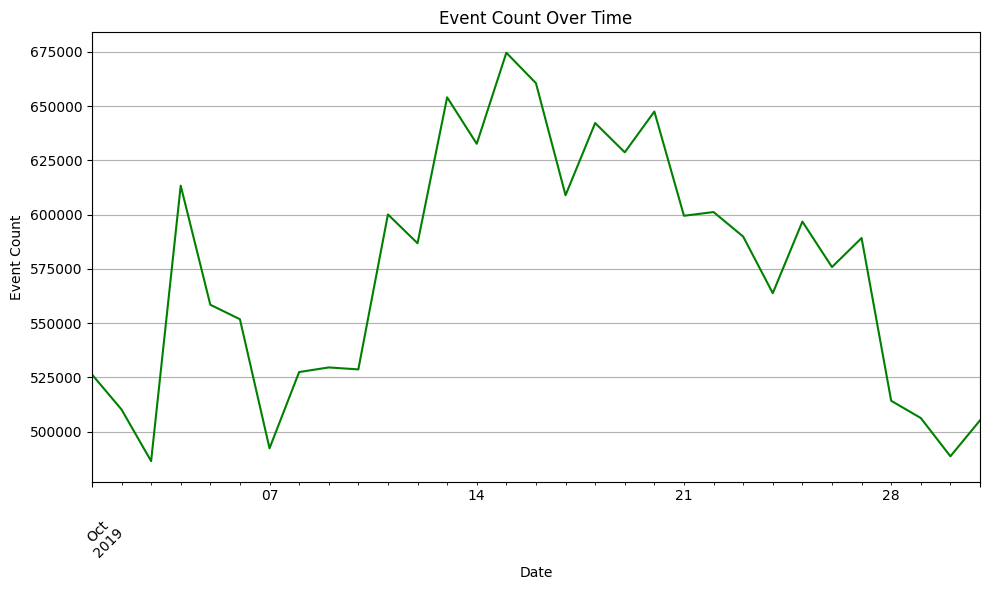

<Figure size 640x480 with 0 Axes>

In [ ]:
event_count_by_date = df.groupby('event_time').size()

plt.figure(figsize=(10, 6))
event_count_by_date.plot(color='green')
plt.title('Event Count Over Time')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

Based on the graph above, it shows that the peak amount of Event Count is on 15 Oct 2019 with the value of 675000.

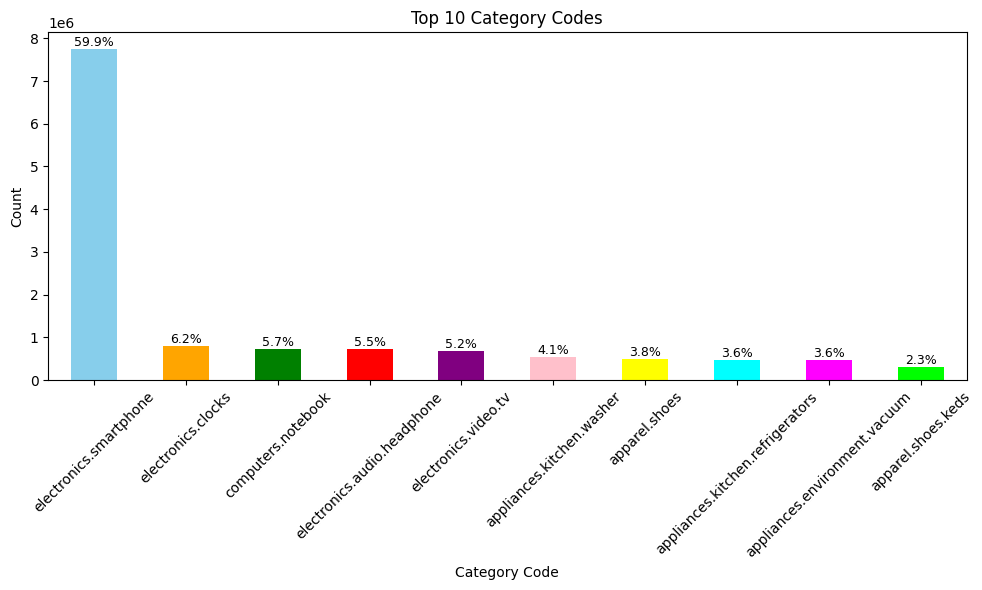

In [ ]:
# Visualizing category code distribution (top 10 categories)
top_categories = df['category_code'].value_counts().nlargest(10)

# Define colors for each bar
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'pink', 'yellow', 'cyan', 'magenta', 'lime']

plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar', color=colors)
plt.title('Top 10 Category Codes')
plt.xlabel('Category Code')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Adding text labels above each bar
total_count = top_categories.sum()
for i, count in enumerate(top_categories):
    percentage = (count / total_count) * 100
    plt.text(i, count + 5, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

The top 10 category involve in user event (view, cart, purchase) is presented in bar graph above. electronics.smartphone is the highest with 59.9%. Note that, there are exist other brands with lowest percentage but didnt include in this graph due to high number of brand types.

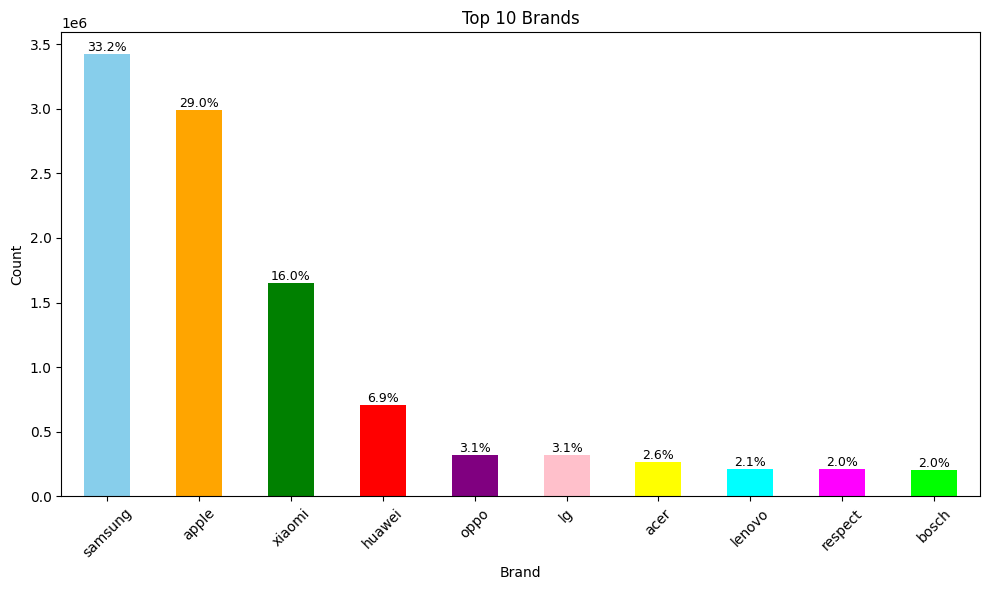

In [ ]:
# Visualizing brand distribution (top 10 brand)
top_brands = df['brand'].value_counts().nlargest(10)

# Define colors for each bar
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'pink', 'yellow', 'cyan', 'magenta', 'lime']

plt.figure(figsize=(10, 6))
ax = top_brands.plot(kind='bar', color=colors)
plt.title('Top 10 Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Adding text labels above each bar
total_count = top_brands.sum()
for i, count in enumerate(top_brands):
    percentage = (count / total_count) * 100
    plt.text(i, count + 5, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


The top 10 brands in involve in user event (view, cart, purchase) is presented in bar graph above. Samsung is the highest with 33.2%. Note that, there are exist other brands with lowest percentage but didnt include in this graph due to high number of brand types.

### 5.3 Data Exploration

When visualizing individual variables, it is important to first understand what type of variable you are dealing with. This will help us find the right visualization method for that variable.

In [ ]:
df.dtypes

event_time       datetime64[ns]
event_type             category
product_id                int32
category_id               int64
category_code          category
brand                  category
price                   float32
user_id                   int32
user_session             string
dtype: object

In [ ]:
# Calculate the purchase behavior of unique users
purchase_behavior = df[df['event_type'] == 'purchase'].groupby('user_id')['event_type'].count()

# Sort purchase behavior to get top 20 purchases
top_20_purchases = purchase_behavior.sort_values(ascending=False).head(20)

# Display the top 20 purchases of users
print('Top 20 User purchased:')
top_20_purchases

Top 20 User purchased:


user_id
512386086    284
513320236    172
549109608    154
543312954    154
519267944    148
513117637    142
547330965    124
538340540    120
547101738    120
558420737    116
530834332    116
556680161    110
525351013    105
535658024    103
538216048    102
545925192    100
551361102     99
513322839     96
557646747     93
538473314     93
Name: event_type, dtype: int64

In [ ]:
purchase_events = df[df['event_type'] == 'purchase']
repurchased_products = purchase_events.groupby(['user_session', 'product_id']).size().reset_index(name='purchase_count')
top_10_repurchased = repurchased_products.sort_values('purchase_count', ascending=False).head(10)

print('Top 10 Repurchased Product:')
top_10_repurchased

Top 10 Repurchased Product:


,user_session,product_id,purchase_count
29504,0eedef43-b496-46a8-a027-70bdb0c1ed22,1004856,7
48685,18c112c2-5470-4318-965e-050913a2e028,1004767,7
301842,985aa12c-d4ab-4e7d-a343-46b55da15e6d,1004856,5
141020,472a87fc-5578-4008-a8ab-dd134bcdf990,1307406,5
141018,472a87fc-5578-4008-a8ab-dd134bcdf990,1004836,4
29502,0eedef43-b496-46a8-a027-70bdb0c1ed22,1004767,4
256507,817d438b-82a2-4add-b17c-ef89cb2edf65,1002544,4
48687,18c112c2-5470-4318-965e-050913a2e028,1004856,4
356077,b3b586ab-daf4-4f43-83f1-dc2692c0ef99,2702347,4
29506,0eedef43-b496-46a8-a027-70bdb0c1ed22,1801712,3


In [ ]:
# Group the DataFrame by 'user_session' and find the first and last event times
session_times = df.groupby('user_session')['event_time'].agg(['min', 'max'])

# Calculate session durations
session_times['session_duration'] = session_times['max'] - session_times['min']

# View the calculated session durations
print('Session Duration: Day Gap Between First and Last Event per User Session: ')
session_times['session_duration']

Session Duration: Day Gap Between First and Last Event per User Session: 


user_session
00000056-a206-40dd-b174-a072550fa38c   0 days
00000083-8816-4d58-a9b8-f52f54186edc   0 days
000001fd-1f89-45e8-a3ce-fe3218cabfad   0 days
000003eb-b63e-45d9-9f26-f229057c654a   0 days
0000047e-bdcc-4854-9e8d-9da7f84010ae   0 days
                                        ...  
fffff1fc-eac8-455c-b280-30e5f94f0e69   0 days
fffff348-977d-497e-b37a-8068b0ef6175   0 days
fffff6b0-1ade-413d-b9b4-5fb0dd26aa34   0 days
fffff79f-a682-4f63-ad94-8364fe3d648f   0 days
fffffa1b-a6f0-483a-8f4b-30db242889b6   0 days
Name: session_duration, Length: 6419693, dtype: timedelta64[ns]

We can say that, all user mostly will come back to the session within the day.

In [ ]:
# Filter purchase and repurchase events
purchase_events = df[df['event_type'] == 'purchase']

# Group by brand and calculate purchase and repurchase counts
purchase_counts = purchase_events.groupby('brand')['event_type'].count()

# Calculate average purchase and repurchase counts per brand
average_purchase_counts = purchase_counts / purchase_events['brand'].nunique()

# Combine average purchase and repurchase counts into one DataFrame
brand_statistics = pd.DataFrame({'Average_Purchase_Count': average_purchase_counts,})

# Find top 5 brands with the largest average purchased and repurchased counts
top_5_brands_purchase = brand_statistics.nlargest(5, 'Average_Purchase_Count')

print("Top 5 Brands with Largest Average Purchase Counts:")
print(top_5_brands_purchase)

Top 5 Brands with Largest Average Purchase Counts:
         Average_Purchase_Count
brand                          
samsung              149.523764
apple                123.735741
xiaomi                40.832700
huawei                20.340304
oppo                   9.426806


In [ ]:
numeric_columns = df.select_dtypes(include=['float32', 'int64', 'int32']).columns
correlation_matrix = df[numeric_columns].corr()
display(correlation_matrix)

,product_id,category_id,price,user_id
product_id,1.000000,0.323025,-0.275551,-0.045002
category_id,0.323025,1.000000,-0.050600,-0.007628
price,-0.275551,-0.050600,1.000000,-0.016312
user_id,-0.045002,-0.007628,-0.016312,1.000000


The columns suitable for correlation analysis appear to be product_id, category_id, user_id and price, as they contain numerical data. However, it's essential to note that using correlation coefficients between non-continuous variables (like product_id, user_id and category_id) might not provide meaningful insights as correlation is primarily used for continuous variables.

The values in the matrix will range between -1 and 1, indicating the strength and direction of the linear relationship between pairs of variables. A value closer to 1 or -1 implies a strong positive or negative correlation, respectively, while a value around 0 indicates a weak correlation.